In [77]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


here the objective is to fit the logit graph model to the brain graphs and then 
visualize the original vs fitted graphs

In [78]:
import sys
import os
sys.path.append('../')

#Graph imports
import src.graph as graph
import src.logit_estimator as estimator
import src.utils as utils
import src.model_selection as model_selection
import src.gic as gic
import src.param_estimator as pe
import src.graph as graph
import src.model_selection as ms

# usual imports
import matplotlib.pyplot as plt
import pickle
import math
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import gaussian_kde
import numpy as np
import pandas as pd
import seaborn as sns
import gc
import random
import networkx as nx
from numpy import errstate

from IPython.display import display
from pyvis.network import Network
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [79]:
PATH = f'../data/connectomes/brain_graph/'
DATASET = f'repeated_10_scale_60'

files = sorted(os.listdir(PATH+DATASET))

In [80]:
# Read the first 10 graphml files
graphs = [nx.read_graphml(PATH+DATASET+'/'+file) for file in files[:30]]

# Create a list of graphs
graphs = [nx.read_graphml(PATH+DATASET+'/'+file) for file in files[:30]]

In [81]:
def visualize_first_n_graphs(graphs, n=10, figsize=(15, 10), node_size=300, font_size=8, edge_width=0.5):
    """
    Visualize the first n graphs in a publication-ready format.
    
    Parameters:
    -----------
    graphs : list
        List of NetworkX graphs
    n : int
        Number of graphs to visualize
    figsize : tuple
        Figure size (width, height)
    node_size : int
        Size of nodes in the visualization
    font_size : int
        Font size for node labels
    edge_width : float
        Width of edges
    
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The created figure
    """
    # Limit n to available graphs
    n = min(n, len(graphs))
    
    # Calculate grid dimensions
    cols = min(4, n)  # Maximum 4 columns
    rows = (n + cols - 1) // cols  # Ceiling division
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    
    # Handle single subplot case
    if n == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes if hasattr(axes, '__iter__') else [axes]
    else:
        axes = axes.flatten()
    
    # Color scheme for publication quality
    node_color = '#4472C4'  # Professional blue
    edge_color = '#8B8B8B'  # Subtle gray
    
    for i in range(n):
        G = graphs[i]
        ax = axes[i]
        
        # Use spring layout for consistent positioning
        pos = nx.spring_layout(G, k=1, iterations=50, seed=42)
        
        # Draw edges first (so they appear behind nodes)
        nx.draw_networkx_edges(G, pos, ax=ax, 
                              edge_color=edge_color, 
                              width=edge_width, 
                              alpha=0.6)
        
        # Draw nodes
        nx.draw_networkx_nodes(G, pos, ax=ax,
                              node_color=node_color,
                              node_size=node_size,
                              alpha=0.8)
        
        # Set title and remove axes
        ax.set_title(f'Graph {i+1}\n({G.number_of_nodes()} nodes, {G.number_of_edges()} edges)',
                    fontsize=font_size+2, fontweight='bold', pad=10)
        ax.axis('off')
    
    # Hide unused subplots
    for i in range(n, len(axes)):
        axes[i].axis('off')
    
    # Adjust layout for publication quality
    plt.tight_layout(pad=2.0)
    
    # Add overall title
    #fig.suptitle(f'Brain Connectome Graphs (First {n} samples)\n\n', 
    #            fontsize=16, fontweight='bold', y=0.98)
    
    return fig


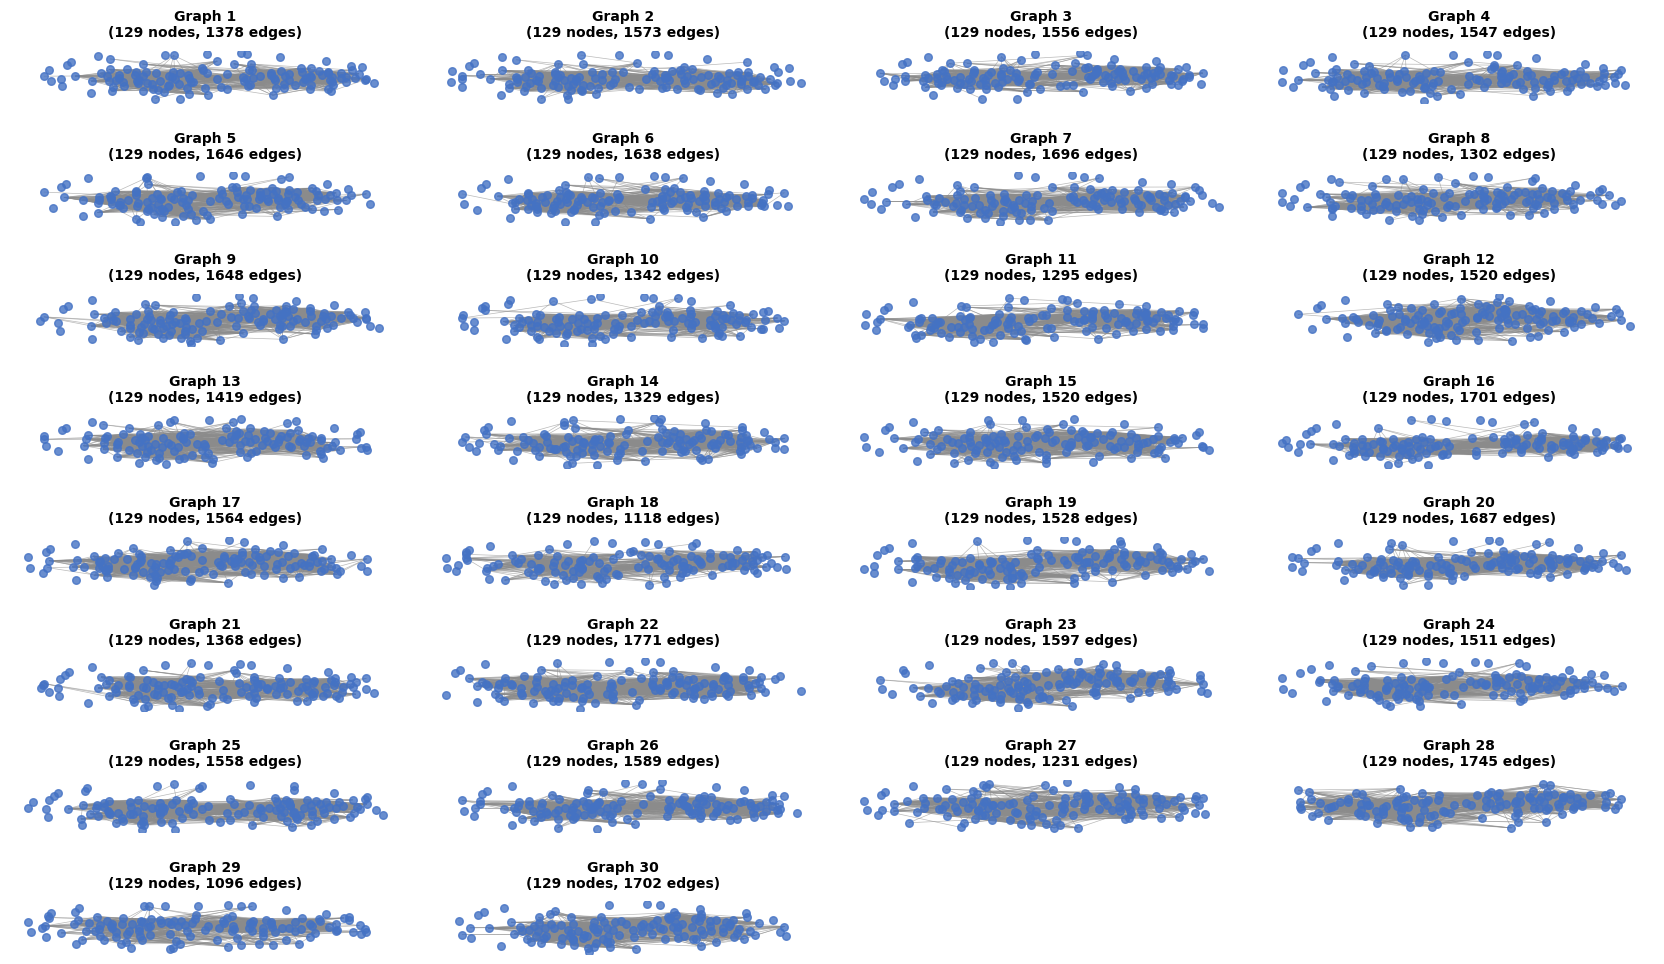

In [82]:
fig = visualize_first_n_graphs(graphs, n=30, figsize=(17, 10), node_size=30, font_size=8, edge_width=0.5)

In [83]:

def get_logit_graph(real_graph, d, n_iteration, warm_up, patience, dist_type='KL', edge_delta=None, min_gic_threshold=None, verbose=True):
   """
   Estimates parameters, generates a graph using the Logit Graph model,
   and calculates GIC, allowing for different convergence criteria.

   Args:
       real_graph (nx.Graph or np.ndarray): The target graph.
       d (int): Parameter for the Logit model (number of neighbors).
       n_iteration (int): Maximum number of iterations for graph generation.
       warm_up (int): Number of initial iterations to discard.
       patience (int): Number of iterations to wait for improvement before stopping.
       dist_type (str): Distance type for GIC ('KL', 'L1', 'L2').
       convergence_criteria (str): Criterion for stopping ('spectrum' or 'spectrum_and_edges').

   Returns:
       tuple: Contains the best generated graph, sigma, GIC values,
              spectrum differences, edge differences, best iteration index, and all graphs.
   """
   # Ensure real_graph is a NumPy array
   if isinstance(real_graph, nx.Graph):
       real_graph = nx.to_numpy_array(real_graph)

   # Estimation
   est = estimator.LogitRegEstimator(real_graph, d=d)
   features, labels = est.get_features_labels()
   # Using default L1 regularization as before, adjust if needed
   result, params, pvalue = est.estimate_parameters(l1_wt=1, alpha=0, features=features, labels=labels)
   sigma = params[0]

   # Generation
   n = real_graph.shape[0]

   params_dict = {
      "n": n,
      "d": d,
      "sigma": sigma,
      "n_iteration": n_iteration,
      "warm_up": warm_up,
      "patience": patience,
      "edge_delta": edge_delta,
   }

   graph_model = graph.GraphModel(n=n, d=d, sigma=sigma)

   print(f"Running generation with convergence criterion: {edge_delta}")
   
   graphs, spec, spectrum_diffs, best_iteration, best_graph_arr = graph_model.populate_edges_spectrum_min_gic(
        max_iterations=n_iteration,
        # warm_up=warm_up,
        patience=patience,
        real_graph=real_graph,
        edge_delta=edge_delta,
        min_gic_threshold=min_gic_threshold,
        gic_dist_type=dist_type,
        verbose=verbose,
    )


   print(f"Finish generation with convergence criterion: {edge_delta}")
   # Calculate edge differences
   real_edges = np.sum(real_graph) / 2
   edge_diffs = [abs(np.sum(g) / 2 - real_edges) for g in graphs]

   # Use the best graph found based on the selected criteria/iteration
   # best_graph = graphs[best_iteration]

   # Calculate GIC for the best graph
   best_graph_nx = nx.from_numpy_array(best_graph_arr)
   gic_value = gic.GraphInformationCriterion(
       graph=nx.from_numpy_array(real_graph),
       log_graph=best_graph_nx,
       model='LG',
       dist_type=dist_type
   ).calculate_gic()

   return best_graph_arr, sigma, [gic_value], spectrum_diffs, edge_diffs, best_iteration, graphs



# Model LG fitting

Here we fit and visualize the logit graph model to the brain graphs

In [42]:
def visualize_original_vs_fitted_graphs(results, figsize=(20, 12), node_size=30, font_size=8, edge_width=0.5, graphs_per_plot=10):
    """
    Visualize original graphs vs fitted LG graphs with GIC values.
    Creates multiple plots with up to graphs_per_plot graphs each.
    
    Parameters:
    -----------
    results : dict
        Results from fit_logit_graphs_to_dataset
    figsize : tuple
        Figure size
    node_size : int
        Size of nodes
    font_size : int
        Font size for labels
    edge_width : float
        Width of edges
    graphs_per_plot : int
        Number of graphs to display per plot
    
    Returns:
    --------
    figs : list
        List of matplotlib.figure.Figure objects
    """
    n_graphs = len(results['original_graphs'])
    
    # Calculate number of plots needed
    n_plots = (n_graphs + graphs_per_plot - 1) // graphs_per_plot
    
    figs = []
    
    # Color schemes
    original_node_color = '#4472C4'  # Blue for original
    fitted_node_color = '#E74C3C'    # Red for fitted
    edge_color = '#8B8B8B'           # Gray for edges
    
    for plot_idx in range(n_plots):
        start_idx = plot_idx * graphs_per_plot
        end_idx = min(start_idx + graphs_per_plot, n_graphs)
        current_n_graphs = end_idx - start_idx
        
        # Create subplot grid: 2 rows (original vs fitted), current_n_graphs columns
        fig, axes = plt.subplots(2, current_n_graphs, figsize=figsize)
        
        # Handle single graph case
        if current_n_graphs == 1:
            axes = axes.reshape(2, 1)
        
        for i in range(current_n_graphs):
            graph_idx = start_idx + i
            original_graph = results['original_graphs'][graph_idx]
            fitted_graph = results['fitted_graphs'][graph_idx]
            gic_value = results['gic_values'][graph_idx]
            stats = results['graph_stats'][graph_idx]
            
            # Plot original graph (top row)
            ax_orig = axes[0, i] if current_n_graphs > 1 else axes[0]
            pos_orig = nx.spring_layout(original_graph, k=1, iterations=50, seed=42)
            
            nx.draw_networkx_edges(original_graph, pos_orig, ax=ax_orig,
                                  edge_color=edge_color, width=edge_width, alpha=0.6)
            nx.draw_networkx_nodes(original_graph, pos_orig, ax=ax_orig,
                                  node_color=original_node_color, node_size=node_size, alpha=0.8)
            
            ax_orig.set_title(f'Original Graph {graph_idx+1}\n({stats["original_nodes"]} nodes, {stats["original_edges"]} edges)',
                             fontsize=font_size+2, fontweight='bold', pad=10)
            ax_orig.axis('off')
            
            # Plot fitted graph (bottom row)
            ax_fitted = axes[1, i] if current_n_graphs > 1 else axes[1]
            
            if fitted_graph is not None and results['fit_success'][graph_idx]:
                pos_fitted = nx.spring_layout(fitted_graph, k=1, iterations=50, seed=42)
                
                nx.draw_networkx_edges(fitted_graph, pos_fitted, ax=ax_fitted,
                                      edge_color=edge_color, width=edge_width, alpha=0.6)
                nx.draw_networkx_nodes(fitted_graph, pos_fitted, ax=ax_fitted,
                                      node_color=fitted_node_color, node_size=node_size, alpha=0.8)
                
                title = f'Fitted LG Graph {graph_idx+1}\n({stats["fitted_nodes"]} nodes, {stats["fitted_edges"]} edges)\nGIC: {gic_value:.4f}'
            else:
                title = f'Fitted LG Graph {graph_idx+1}\n(Fitting Failed)'
            
            ax_fitted.set_title(title, fontsize=font_size+2, fontweight='bold', pad=10)
            ax_fitted.axis('off')
        
        # Add overall title for this plot
        fig.suptitle(f'Original Brain Connectomes vs Fitted Logit Graph Models (Graphs {start_idx+1}-{end_idx})', 
                    fontsize=16, fontweight='bold', y=0.95)
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.92])
        figs.append(fig)
    
    return figs


In [27]:
def fit_logit_graphs_to_dataset(graphs, n_graphs=5, sim_params=None):
    """
    Fit logit graph models to the first n graphs in the dataset.
    
    Parameters:
    -----------
    graphs : list
        List of NetworkX graphs
    n_graphs : int
        Number of graphs to process
    sim_params : dict
        Simulation parameters for logit graph fitting
    
    Returns:
    --------
    results : dict
        Dictionary containing original graphs, fitted graphs, and GIC values
    """
    if sim_params is None:
        sim_params = {
            "d": 0,
            "n_iteration": 10000,  # Reduced for faster computation
            "warm_up": 500,
            "patience": 2000,
            "dist_type": 'KL',
            "min_gic_threshold": 5,
            "verbose": True,
        }
    
    results = {
        'original_graphs': [],
        'fitted_graphs': [],
        'gic_values': [],
        'fit_success': [],
        'graph_stats': []
    }
    
    n_graphs = min(n_graphs, len(graphs))
    
    for i in range(n_graphs):
        print(f"\n{'='*20} Processing Graph {i+1}/{n_graphs} {'='*20}")
        
        original_graph = graphs[i]
        adj_matrix = nx.to_numpy_array(original_graph)
        n_nodes = original_graph.number_of_nodes()
        n_edges = original_graph.number_of_edges()
        
        print(f"Original graph - Nodes: {n_nodes}, Edges: {n_edges}")
        
        try:
            # Fit logit graph model
            logit_results = get_logit_graph(
                real_graph=adj_matrix.copy(),
                d=sim_params["d"],
                n_iteration=sim_params["n_iteration"],
                warm_up=sim_params["warm_up"],
                patience=sim_params["patience"],
                dist_type=sim_params["dist_type"],
                edge_delta=None,  # Use spectrum convergence only
                min_gic_threshold=sim_params["min_gic_threshold"],
                verbose=sim_params["verbose"],
            )
            
            fitted_adj_matrix = logit_results[0]
            fitted_graph = nx.from_numpy_array(fitted_adj_matrix)
            gic_value = logit_results[2][0]
            best_iteration = logit_results[5]
            
            results['original_graphs'].append(original_graph)
            results['fitted_graphs'].append(fitted_graph)
            results['gic_values'].append(gic_value)
            results['fit_success'].append(True)
            results['graph_stats'].append({
                'original_nodes': n_nodes,
                'original_edges': n_edges,
                'fitted_nodes': fitted_graph.number_of_nodes(),
                'fitted_edges': fitted_graph.number_of_edges(),
                'best_iteration': best_iteration
            })
            
            print(f"Fitting successful - GIC: {gic_value:.4f}, Best iteration: {best_iteration}")
            print(f"Fitted graph - Nodes: {fitted_graph.number_of_nodes()}, Edges: {fitted_graph.number_of_edges()}")
            
        except Exception as e:
            print(f"Error fitting graph {i+1}: {e}")
            results['original_graphs'].append(original_graph)
            results['fitted_graphs'].append(None)
            results['gic_values'].append(np.nan)
            results['fit_success'].append(False)
            results['graph_stats'].append({
                'original_nodes': n_nodes,
                'original_edges': n_edges,
                'fitted_nodes': 0,
                'fitted_edges': 0,
                'best_iteration': 0
            })
        
        gc.collect()  # Clean up memory
    
    return results


In [47]:
def print_fitting_summary(results):
    """Print summary of fitting results and return a dataframe."""
    import pandas as pd
    
    n_graphs = len(results['original_graphs'])
    successful_fits = sum(results['fit_success'])
    
    print(f"\n{'='*50}")
    print(f"LOGIT GRAPH FITTING SUMMARY")
    print(f"{'='*50}")
    print(f"Total graphs processed: {n_graphs}")
    print(f"Successful fits: {successful_fits}/{n_graphs}")
    print(f"Success rate: {successful_fits/n_graphs*100:.1f}%")
    
    if successful_fits > 0:
        valid_gics = [gic for gic, success in zip(results['gic_values'], results['fit_success']) 
                     if success and not np.isnan(gic)]
        if valid_gics:
            print(f"\nGIC Statistics:")
            print(f"  Mean GIC: {np.mean(valid_gics):.4f}")
            print(f"  Std GIC: {np.std(valid_gics):.4f}")
            print(f"  Min GIC: {np.min(valid_gics):.4f}")
            print(f"  Max GIC: {np.max(valid_gics):.4f}")
    
    print(f"\nDetailed Results:")
    
    # Create dataframe with detailed results
    df_data = []
    for i, (gic, success, stats) in enumerate(zip(results['gic_values'], results['fit_success'], results['graph_stats'])):
        status = "SUCCESS" if success else "FAILED"
        gic_value = gic if success and not np.isnan(gic) else np.nan
        
        print(f"  Graph {i+1}: {status} | GIC: {gic_value if not np.isnan(gic_value) else 'N/A'} | "
              f"Orig: {stats['original_nodes']}n/{stats['original_edges']}e | "
              f"Fitted: {stats['fitted_nodes']}n/{stats['fitted_edges']}e")
        
        df_data.append({
            'graph_id': i+1,
            'status': status,
            'fit_success': success,
            'gic_value': gic_value,
            'original_nodes': stats['original_nodes'],
            'original_edges': stats['original_edges'],
            'fitted_nodes': stats['fitted_nodes'],
            'fitted_edges': stats['fitted_edges'],
            'best_iteration': stats['best_iteration']
        })
    
    df = pd.DataFrame(df_data)
    return df


In [29]:
# Define simulation parameters for faster computation on multiple graphs
sim_params = {
    "d": 0,
    "n_iteration": 8000,   # Reduced for faster computation
    "warm_up": 500,
    "patience": 1500,      # Reduced patience
    "dist_type": 'KL',
    "min_gic_threshold": 5,
    "verbose": True,
}

# Fit logit graphs to the first 5 graphs
print("Starting logit graph fitting experiment...")
fitting_results = fit_logit_graphs_to_dataset(graphs, n_graphs=30, sim_params=sim_params)

Starting logit graph fitting experiment...

==================== Processing Graph 1/30 ====================
Original graph - Nodes: 129, Edges: 1463
Running generation with convergence criterion: None
iteration: 0
	 Current GIC (KL): inf (Threshold: 5)
	 Best Spectrum Diff: inf
	 Patience: 0/1500
	 Current edges: 0.0 (Real edges: 1463.0)
iteration: 1000
	 Current GIC (KL): 14.6817 (Threshold: 5)
	 Best Spectrum Diff: 318.3026
	 Patience: 0/1500
	 Current edges: 7.0 (Real edges: 1463.0)

*** GIC threshold 5 reached at iteration 1591 (GIC: 4.1305) ***
*** Starting convergence check based on spectrum difference (Patience: 1500) ***

iteration: 2000
	 Best Spectrum Diff: 315.8367
	 Patience: 136/1500
	 Current edges: 15.0 (Real edges: 1463.0)
iteration: 3000
	 Best Spectrum Diff: 309.3231
	 Patience: 35/1500
	 Current edges: 38.0 (Real edges: 1463.0)
iteration: 4000
	 Best Spectrum Diff: 284.7614
	 Patience: 0/1500
	 Current edges: 134.0 (Real edges: 1463.0)
iteration: 5000
	 Best Spectrum

In [30]:
import pickle
import os
os.makedirs(f'runs/fitting_results_braingraph_{DATASET}', exist_ok=True)
with open(f'runs/fitting_results_braingraph_{DATASET}/fitting_results.pkl', 'wb') as f:
    pickle.dump(fitting_results, f)


In [48]:
# Print summary of results
df_results = print_fitting_summary(fitting_results)
df_results.to_csv(f'runs/fitting_results_braingraph_{DATASET}/fitting_results.csv', index=False)


LOGIT GRAPH FITTING SUMMARY
Total graphs processed: 30
Successful fits: 30/30
Success rate: 100.0%

GIC Statistics:
  Mean GIC: 2.0191
  Std GIC: 1.0228
  Min GIC: 0.6172
  Max GIC: 3.7622

Detailed Results:
  Graph 1: SUCCESS | GIC: 0.8976121037135039 | Orig: 129n/1463e | Fitted: 129n/1461e
  Graph 2: SUCCESS | GIC: 3.00185717021595 | Orig: 129n/1332e | Fitted: 129n/1431e
  Graph 3: SUCCESS | GIC: 0.6383484961147545 | Orig: 129n/1541e | Fitted: 129n/1596e
  Graph 4: SUCCESS | GIC: 1.5097629558072014 | Orig: 129n/1441e | Fitted: 129n/1523e
  Graph 5: SUCCESS | GIC: 2.8807029531423445 | Orig: 129n/1458e | Fitted: 129n/1522e
  Graph 6: SUCCESS | GIC: 0.6965856857863855 | Orig: 129n/1378e | Fitted: 129n/1468e
  Graph 7: SUCCESS | GIC: 2.0148734525020773 | Orig: 129n/1403e | Fitted: 129n/1470e
  Graph 8: SUCCESS | GIC: 1.1782736174764241 | Orig: 129n/1697e | Fitted: 129n/1758e
  Graph 9: SUCCESS | GIC: 0.7634571038147133 | Orig: 129n/1459e | Fitted: 129n/1487e
  Graph 10: SUCCESS | GIC: 2

In [51]:
display(df_results.head()), df_results['gic_value'].describe()

graph_id   status  fit_success  gic_value  original_nodes  original_edges  \
0         1  SUCCESS         True   0.897612             129            1463   
1         2  SUCCESS         True   3.001857             129            1332   
2         3  SUCCESS         True   0.638348             129            1541   
3         4  SUCCESS         True   1.509763             129            1441   
4         5  SUCCESS         True   2.880703             129            1458   

   fitted_nodes  fitted_edges  best_iteration  
0           129          1461            5753  
1           129          1431            5657  
2           129          1596            4624  
3           129          1523            4689  
4           129          1522            5010

(None,
 count    30.000000
 mean      2.019099
 std       1.040251
 min       0.617168
 25%       0.930923
 50%       2.170490
 75%       2.978244
 max       3.762156
 Name: gic_value, dtype: float64)

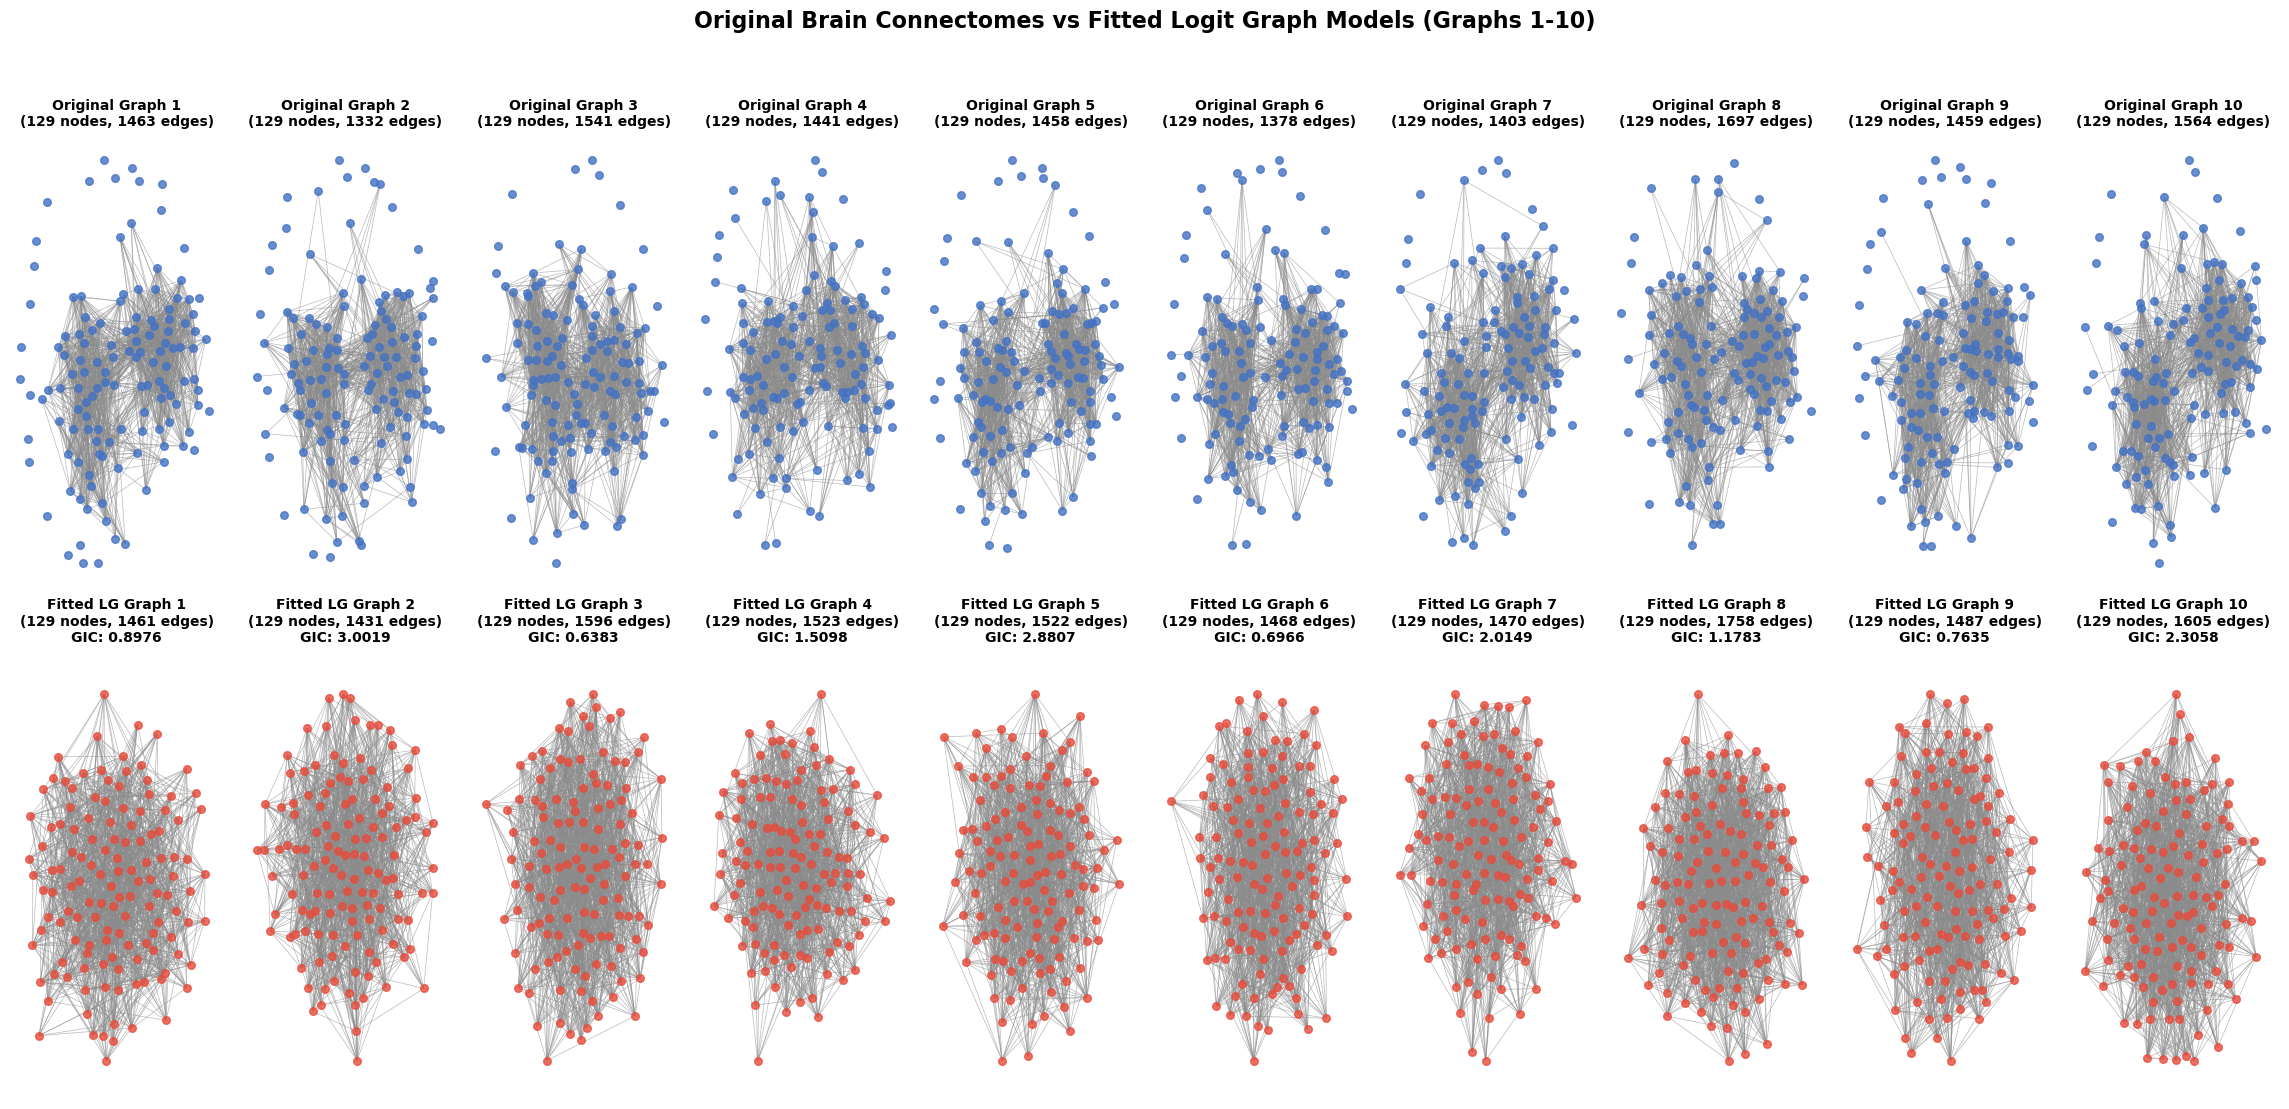

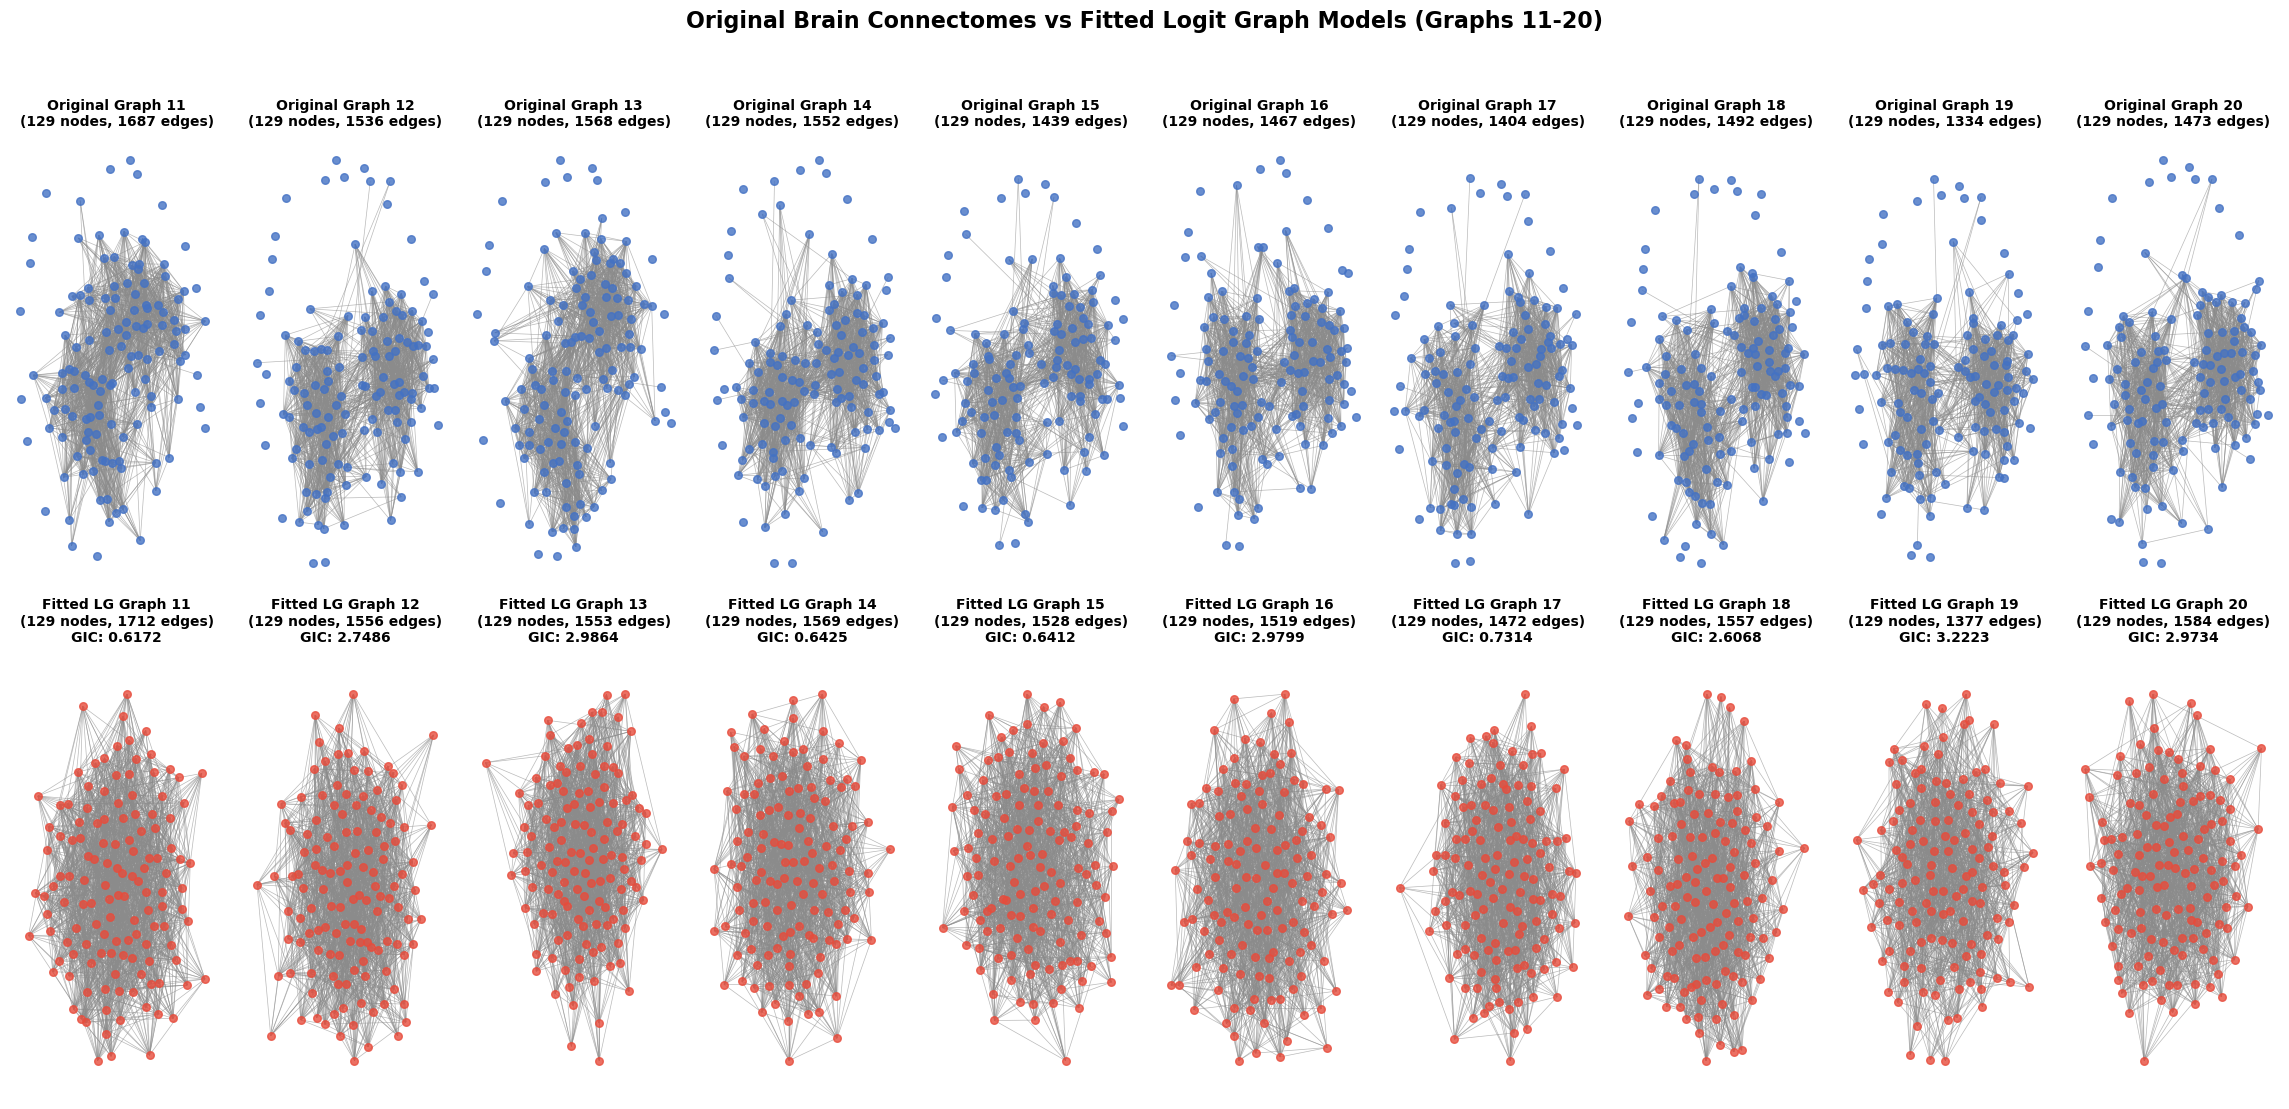

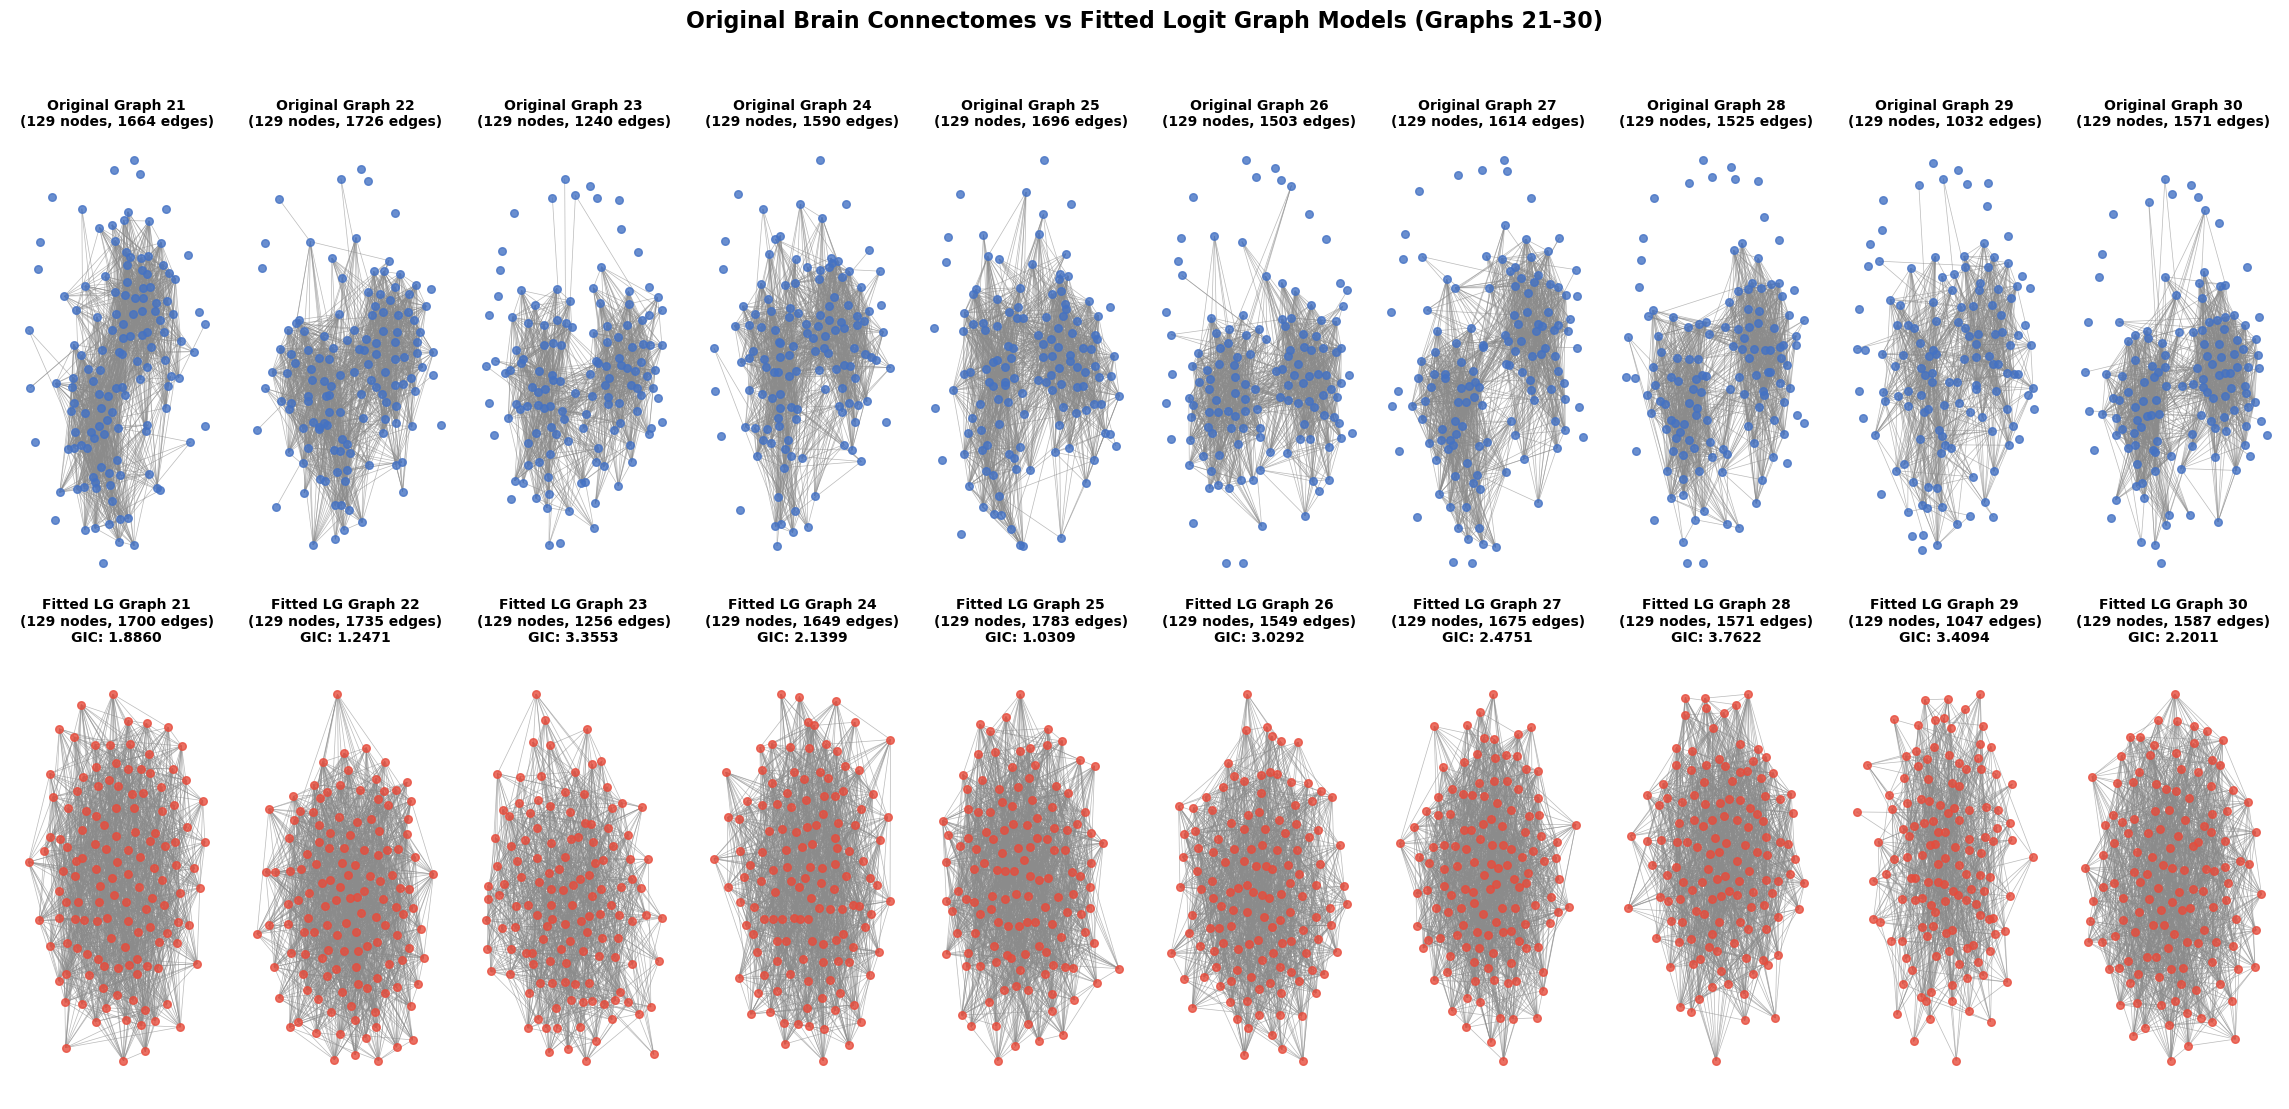

In [44]:
# Create the comparison visualization
fig_comparison = visualize_original_vs_fitted_graphs(
    fitting_results, 
    figsize=(23, 12), 
    node_size=30, 
    font_size=8, 
    edge_width=0.5
)

In [46]:
import os
os.makedirs(f'../images/fitting_results_braingraph_{DATASET}', exist_ok=True)
with open(f'../images/fitting_results_braingraph_{DATASET}/original_vs_fitted_lg_graphs.pkl', 'wb') as f:
    pickle.dump(fig_comparison, f)

# Comparision LG with other models

here we compare the logit graph model with other models

In [84]:
def create_summary_dataframe(graph_results):
    """Create a summary DataFrame from the results."""
    df_data = []
    
    for graph_result in graph_results:
        graph_id = graph_result['graph_id']
        original_nodes = graph_result['original_nodes']
        original_edges = graph_result['original_edges']
        
        for model_name, model_data in graph_result['models'].items():
            df_data.append({
                'graph_id': graph_id,
                'model': model_name,
                'gic_value': model_data['gic_value'],
                'param': model_data['param'],
                'fit_success': model_data['fit_success'],
                'original_nodes': original_nodes,
                'original_edges': original_edges,
                'fitted_nodes': model_data['fitted_nodes'],
                'fitted_edges': model_data['fitted_edges'],
                'best_iteration': model_data['best_iteration']
            })
    
    return pd.DataFrame(df_data)


In [85]:
def clean_and_convert(param):
    """Clean and convert parameter string to float."""
    cleaned_param = ''.join(c for c in str(param) if c.isdigit() or c == '.' or c == '-')
    try:
        return float(cleaned_param)
    except:
        return np.nan


def fit_multiple_models_to_dataset(graphs, n_graphs=5, sim_params=None):
    """
    Fit LG and other random graph models to the first n graphs in the dataset.
    
    Parameters:
    -----------
    graphs : list
        List of NetworkX graphs
    n_graphs : int
        Number of graphs to process
    sim_params : dict
        Simulation parameters for logit graph fitting
    
    Returns:
    --------
    results : dict
        Dictionary containing all results for each graph and model, including fitted_graphs dict
    """
    if sim_params is None:
        sim_params = {
            "d": 0,
            "n_iteration": 8000,
            "warm_up": 500,
            "patience": 1500,
            "edge_delta": None,
            "min_gic_threshold": 5,
            "dist_type": 'KL',
            "verbose": True,
        }
    
    results = {
        'graph_results': [],  # List of results for each graph
        'summary_df': None,
        'fitted_graphs': {}  # Dict with graph names as keys and fitted graphs as values
    }
    
    n_graphs = min(n_graphs, len(graphs))
    
    for i in range(n_graphs):
        print(f"\n{'='*30} Processing Graph {i+1}/{n_graphs} {'='*30}")
        
        original_graph = graphs[i]
        adj_matrix = nx.to_numpy_array(original_graph)
        n_nodes = original_graph.number_of_nodes()
        n_edges = original_graph.number_of_edges()
        
        print(f"Original graph - Nodes: {n_nodes}, Edges: {n_edges}")
        
        graph_result = {
            'graph_id': i+1,
            'original_graph': original_graph,
            'original_nodes': n_nodes,
            'original_edges': n_edges,
            'models': {}
        }
        
        # 1. Fit Logit Graph (LG) model
        print("\n--- Fitting Logit Graph (LG) ---")
        logit_results = get_logit_graph(
            real_graph=adj_matrix.copy(),
            d=sim_params["d"],
            n_iteration=sim_params["n_iteration"],
            warm_up=sim_params["warm_up"],
            patience=sim_params["patience"],
            dist_type=sim_params["dist_type"],
            edge_delta=sim_params["edge_delta"],
            min_gic_threshold=sim_params["min_gic_threshold"],
            verbose=sim_params["verbose"]
        )
        
        fitted_adj_matrix = logit_results[0]
        fitted_graph = nx.from_numpy_array(fitted_adj_matrix)
        gic_value = logit_results[2][0]
        sigma = logit_results[1]
        best_iteration = logit_results[4]
        
        graph_result['models']['LG'] = {
            'fitted_graph': fitted_graph,
            'gic_value': gic_value,
            'param': sigma,
            'fit_success': True,
            'fitted_nodes': fitted_graph.number_of_nodes(),
            'fitted_edges': fitted_graph.number_of_edges(),
            'best_iteration': best_iteration
        }
        
        # Add to fitted_graphs dict
        results['fitted_graphs'][f'graph_{i+1}_LG'] = fitted_graph
        
        print(f"LG fitting successful - GIC: {gic_value:.4f}, Sigma: {sigma:.4f}")
            
        # 2. Fit other random graph models
        print("\n--- Fitting Other Random Graph Models ---")
        
        # Create model selector
        selector = ms.GraphModelSelection(
            graph=original_graph,
            log_graphs=[fitted_graph] if graph_result['models']['LG']['fit_success'] else [original_graph],
            log_params=[graph_result['models']['LG']['param']] if graph_result['models']['LG']['fit_success'] else [1.0],
            models=["ER", "WS", "GRG", "BA"],
            n_runs=5,
            parameters=[
                {'lo': 0.01, 'hi': 1},  # ER
                {'lo': 0.01, 'hi': 1},  # WS k=8
                {'lo': 1, 'hi': 3},     # GRG
                {'lo': 1, 'hi': 5},     # BA
            ]
        )
        
        try:
            model_results = selector.select_model_avg_spectrum()
            
            for estimate in model_results['estimates']:
                model_name = estimate['model']
                if model_name != 'LG':  # LG already processed
                    param = clean_and_convert(estimate['param'])
                    gic_value = estimate['GIC']
                    
                    # Generate the fitted graph
                    func = selector.model_function(model_name=model_name)
                    fitted_graph = func(n_nodes, param)
                    
                    graph_result['models'][model_name] = {
                        'fitted_graph': fitted_graph,
                        'gic_value': gic_value,
                        'param': param,
                        'fit_success': True,
                        'fitted_nodes': fitted_graph.number_of_nodes(),
                        'fitted_edges': fitted_graph.number_of_edges(),
                        'best_iteration': None
                    }
                    
                    # Add to fitted_graphs dict
                    results['fitted_graphs'][f'graph_{i+1}_{model_name}'] = fitted_graph
                    
                    print(f"{model_name} fitting - GIC: {gic_value:.4f}, Param: {param:.4f}")
                    
        except Exception as e:
            print(f"Error fitting other models: {e}")
            for model_name in ["ER", "WS", "GRG", "BA"]:
                graph_result['models'][model_name] = {
                    'fitted_graph': None,
                    'gic_value': np.inf,
                    'param': np.nan,
                    'fit_success': False,
                    'fitted_nodes': 0,
                    'fitted_edges': 0,
                    'best_iteration': None
                }
        
        results['graph_results'].append(graph_result)
        gc.collect()  # Clean up memory
    
    # Create summary DataFrame
    results['summary_df'] = create_summary_dataframe(results['graph_results'])
    
    return results


In [86]:

def visualize_model_comparison(results, figsize=(25, 15), node_size=30, font_size=8, edge_width=0.5):
    """
    Visualize original graphs vs LG vs best fitting model for each graph.
    
    Parameters:
    -----------
    results : dict
        Results from fit_multiple_models_to_dataset
    figsize : tuple
        Figure size
    node_size : int
        Size of nodes
    font_size : int
        Font size for labels
    edge_width : float
        Width of edges
    
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The created figure
    """
    graph_results = results['graph_results']
    n_graphs = len(graph_results)
    
    # Create subplot grid: 3 rows (original, LG, best model), n_graphs columns
    fig, axes = plt.subplots(3, n_graphs, figsize=figsize)
    
    # Handle single graph case
    if n_graphs == 1:
        axes = axes.reshape(3, 1)
    
    # Color schemes
    original_color = '#4472C4'    # Blue for original
    lg_color = '#E74C3C'          # Red for LG
    best_color = '#2ECC71'        # Green for best model
    edge_color = '#8B8B8B'        # Gray for edges
    
    for i, graph_result in enumerate(graph_results):
        original_graph = graph_result['original_graph']
        lg_data = graph_result['models']['LG']
        
        # Find best model (lowest GIC)
        valid_models = {name: data for name, data in graph_result['models'].items() 
                       if data['fit_success'] and not np.isinf(data['gic_value'])}
        
        if valid_models:
            best_model_name = min(valid_models.keys(), key=lambda k: valid_models[k]['gic_value'])
            best_model_data = valid_models[best_model_name]
        else:
            best_model_name = "None"
            best_model_data = None
        
        # Plot original graph (top row)
        ax_orig = axes[0, i]
        pos_orig = nx.spring_layout(original_graph, k=1, iterations=50, seed=42)
        
        nx.draw_networkx_edges(original_graph, pos_orig, ax=ax_orig,
                              edge_color=edge_color, width=edge_width, alpha=0.6)
        nx.draw_networkx_nodes(original_graph, pos_orig, ax=ax_orig,
                              node_color=original_color, node_size=node_size, alpha=0.8)
        
        ax_orig.set_title(f'Original Graph {i+1}\n({graph_result["original_nodes"]} nodes, {graph_result["original_edges"]} edges)',
                         fontsize=font_size+2, fontweight='bold', pad=10)
        ax_orig.axis('off')
        
        # Plot LG fitted graph (middle row)
        ax_lg = axes[1, i]
        
        if lg_data['fitted_graph'] is not None and lg_data['fit_success']:
            pos_lg = nx.spring_layout(lg_data['fitted_graph'], k=1, iterations=50, seed=42)
            
            nx.draw_networkx_edges(lg_data['fitted_graph'], pos_lg, ax=ax_lg,
                                  edge_color=edge_color, width=edge_width, alpha=0.6)
            nx.draw_networkx_nodes(lg_data['fitted_graph'], pos_lg, ax=ax_lg,
                                  node_color=lg_color, node_size=node_size, alpha=0.8)
            
            title = f'LG Model\n({lg_data["fitted_nodes"]} nodes, {lg_data["fitted_edges"]} edges)\nGIC: {lg_data["gic_value"]:.4f}'
        else:
            title = f'LG Model\n(Fitting Failed)'
        
        ax_lg.set_title(title, fontsize=font_size+2, fontweight='bold', pad=10)
        ax_lg.axis('off')
        
        # Plot best model (bottom row)
        ax_best = axes[2, i]
        
        if best_model_data is not None and best_model_data['fitted_graph'] is not None:
            pos_best = nx.spring_layout(best_model_data['fitted_graph'], k=1, iterations=50, seed=42)
            
            nx.draw_networkx_edges(best_model_data['fitted_graph'], pos_best, ax=ax_best,
                                  edge_color=edge_color, width=edge_width, alpha=0.6)
            nx.draw_networkx_nodes(best_model_data['fitted_graph'], pos_best, ax=ax_best,
                                  node_color=best_color, node_size=node_size, alpha=0.8)
            
            title = f'Best Model: {best_model_name}\n({best_model_data["fitted_nodes"]} nodes, {best_model_data["fitted_edges"]} edges)\nGIC: {best_model_data["gic_value"]:.4f}'
        else:
            title = f'Best Model: {best_model_name}\n(No valid fits)'
        
        ax_best.set_title(title, fontsize=font_size+2, fontweight='bold', pad=10)
        ax_best.axis('off')
    
    # Add overall title
    fig.suptitle('Brain Connectomes: Original vs LG vs Best Random Graph Model', 
                fontsize=18, fontweight='bold', y=0.95)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.92])
    return fig

def calculate_graph_attributes(graph):
    """
    Calculate various graph attributes for a given graph.
    
    Parameters:
    -----------
    graph : networkx.Graph
        The graph to analyze
    
    Returns:
    --------
    dict : Dictionary containing graph attributes
    """
    if graph is None or graph.number_of_nodes() == 0:
        return {
            'degree_centrality_mean': np.nan,
            'degree_centrality_std': np.nan,
            'betweenness_centrality_mean': np.nan,
            'betweenness_centrality_std': np.nan,
            'closeness_centrality_mean': np.nan,
            'closeness_centrality_std': np.nan,
            'eigenvector_centrality_mean': np.nan,
            'eigenvector_centrality_std': np.nan,
            'clustering_coefficient_mean': np.nan,
            'clustering_coefficient_std': np.nan,
            'average_path_length': np.nan,
            'diameter': np.nan,
            'density': np.nan,
            'transitivity': np.nan,
            'assortativity': np.nan,
            'number_of_components': np.nan,
            'largest_component_size': np.nan
        }
    
    try:
        # Basic properties
        density = nx.density(graph)
        transitivity = nx.transitivity(graph)
        
        # Centrality measures
        degree_centrality = nx.degree_centrality(graph)
        betweenness_centrality = nx.betweenness_centrality(graph)
        closeness_centrality = nx.closeness_centrality(graph)
        
        # Eigenvector centrality (handle disconnected graphs)
        try:
            eigenvector_centrality = nx.eigenvector_centrality(graph, max_iter=1000)
        except:
            eigenvector_centrality = {node: 0 for node in graph.nodes()}
        
        # Clustering coefficient
        clustering_coefficient = nx.clustering(graph)
        
        # Path-based measures (only for connected graphs)
        if nx.is_connected(graph):
            average_path_length = nx.average_shortest_path_length(graph)
            diameter = nx.diameter(graph)
        else:
            # For disconnected graphs, calculate on largest component
            largest_cc = max(nx.connected_components(graph), key=len)
            largest_subgraph = graph.subgraph(largest_cc)
            if len(largest_cc) > 1:
                average_path_length = nx.average_shortest_path_length(largest_subgraph)
                diameter = nx.diameter(largest_subgraph)
            else:
                average_path_length = 0
                diameter = 0
        
        # Assortativity
        try:
            assortativity = nx.degree_assortativity_coefficient(graph)
        except:
            assortativity = np.nan
        
        # Component analysis
        components = list(nx.connected_components(graph))
        number_of_components = len(components)
        largest_component_size = len(max(components, key=len)) if components else 0
        
        return {
            'degree_centrality_mean': np.mean(list(degree_centrality.values())),
            'degree_centrality_std': np.std(list(degree_centrality.values())),
            'betweenness_centrality_mean': np.mean(list(betweenness_centrality.values())),
            'betweenness_centrality_std': np.std(list(betweenness_centrality.values())),
            'closeness_centrality_mean': np.mean(list(closeness_centrality.values())),
            'closeness_centrality_std': np.std(list(closeness_centrality.values())),
            'eigenvector_centrality_mean': np.mean(list(eigenvector_centrality.values())),
            'eigenvector_centrality_std': np.std(list(eigenvector_centrality.values())),
            'clustering_coefficient_mean': np.mean(list(clustering_coefficient.values())),
            'clustering_coefficient_std': np.std(list(clustering_coefficient.values())),
            'average_path_length': average_path_length,
            'diameter': diameter,
            'density': density,
            'transitivity': transitivity,
            'assortativity': assortativity,
            'number_of_components': number_of_components,
            'largest_component_size': largest_component_size
        }
    
    except Exception as e:
        print(f"Error calculating graph attributes: {e}")
        return {
            'degree_centrality_mean': np.nan,
            'degree_centrality_std': np.nan,
            'betweenness_centrality_mean': np.nan,
            'betweenness_centrality_std': np.nan,
            'closeness_centrality_mean': np.nan,
            'closeness_centrality_std': np.nan,
            'eigenvector_centrality_mean': np.nan,
            'eigenvector_centrality_std': np.nan,
            'clustering_coefficient_mean': np.nan,
            'clustering_coefficient_std': np.nan,
            'average_path_length': np.nan,
            'diameter': np.nan,
            'density': np.nan,
            'transitivity': np.nan,
            'assortativity': np.nan,
            'number_of_components': np.nan,
            'largest_component_size': np.nan
        }

def analyze_fitted_graphs_attributes(results):
    """
    Calculate graph attributes for all fitted graphs in the results.
    
    Parameters:
    -----------
    results : dict
        Results from fit_multiple_models_to_dataset
    
    Returns:
    --------
    dict : Dictionary containing graph attributes for all graphs
    """
    graph_attributes = {}
    
    print("Calculating graph attributes for fitted graphs...")
    
    # Analyze original graphs
    for graph_result in results['graph_results']:
        graph_id = graph_result['graph_id']
        original_graph = graph_result['original_graph']
        
        print(f"Analyzing original graph {graph_id}...")
        graph_attributes[f'graph_{graph_id}_original'] = calculate_graph_attributes(original_graph)
        
        # Analyze fitted models
        for model_name, model_data in graph_result['models'].items():
            if model_data['fit_success'] and model_data['fitted_graph'] is not None:
                print(f"Analyzing {model_name} model for graph {graph_id}...")
                graph_attributes[f'graph_{graph_id}_{model_name}'] = calculate_graph_attributes(model_data['fitted_graph'])
    
    return graph_attributes

def create_attributes_comparison_dataframe(results, graph_attributes):
    """
    Create a DataFrame comparing graph attributes across models.
    
    Parameters:
    -----------
    results : dict
        Results from fit_multiple_models_to_dataset
    graph_attributes : dict
        Graph attributes from analyze_fitted_graphs_attributes
    
    Returns:
    --------
    pandas.DataFrame : DataFrame with graph attributes comparison
    """
    rows = []
    
    for graph_result in results['graph_results']:
        graph_id = graph_result['graph_id']
        
        # Add original graph
        orig_attrs = graph_attributes.get(f'graph_{graph_id}_original', {})
        row = {
            'graph_id': graph_id,
            'model': 'Original',
            'gic_value': np.nan,
            'fit_success': True,
            **orig_attrs
        }
        rows.append(row)
        
        # Add fitted models
        for model_name, model_data in graph_result['models'].items():
            attrs = graph_attributes.get(f'graph_{graph_id}_{model_name}', {})
            row = {
                'graph_id': graph_id,
                'model': model_name,
                'gic_value': model_data['gic_value'] if model_data['fit_success'] else np.nan,
                'fit_success': model_data['fit_success'],
                **attrs
            }
            rows.append(row)
    
    return pd.DataFrame(rows)

def print_model_comparison_summary(results):
    """Print summary of model comparison results."""
    df = results['summary_df']
    graph_results = results['graph_results']
    
    print(f"\n{'='*60}")
    print(f"MODEL COMPARISON SUMMARY")
    print(f"{'='*60}")
    print(f"Total graphs processed: {len(graph_results)}")
    
    # Success rates by model
    print(f"\nSuccess Rates by Model:")
    for model in df['model'].unique():
        model_df = df[df['model'] == model]
        success_rate = model_df['fit_success'].mean() * 100
        print(f"  {model}: {success_rate:.1f}%")
    
    # GIC statistics by model
    print(f"\nGIC Statistics by Model:")
    for model in df['model'].unique():
        model_df = df[(df['model'] == model) & (df['fit_success'] == True)]
        if len(model_df) > 0:
            valid_gics = model_df[model_df['gic_value'] != np.inf]['gic_value']
            if len(valid_gics) > 0:
                print(f"  {model}: Mean={valid_gics.mean():.4f}, Std={valid_gics.std():.4f}, Min={valid_gics.min():.4f}, Max={valid_gics.max():.4f}")
            else:
                print(f"  {model}: No valid GIC values")
        else:
            print(f"  {model}: No successful fits")
    
    # Best model for each graph
    print(f"\nBest Model for Each Graph (by GIC):")
    for graph_result in graph_results:
        graph_id = graph_result['graph_id']
        valid_models = {name: data for name, data in graph_result['models'].items() 
                       if data['fit_success'] and not np.isinf(data['gic_value'])}
        
        if valid_models:
            best_model = min(valid_models.keys(), key=lambda k: valid_models[k]['gic_value'])
            best_gic = valid_models[best_model]['gic_value']
            print(f"  Graph {graph_id}: {best_model} (GIC: {best_gic:.4f})")
        else:
            print(f"  Graph {graph_id}: No valid fits")



In [ ]:
#
# Define simulation parameters
#

sim_params = {
    "d": 0,
    "n_iteration": 8000,
    "warm_up": 500,
    "edge_delta": None,
    "min_gic_threshold": 3,
    "patience": 1500,
    "dist_type": 'KL',
    "min_gic_threshold": 5,
    "verbose": True,
}

print("Starting expanded model comparison experiment...")
model_results = fit_multiple_models_to_dataset(graphs, n_graphs=10, sim_params=sim_params)

Starting expanded model comparison experiment...

============================== Processing Graph 1/10 ==============================
Original graph - Nodes: 129, Edges: 1378

--- Fitting Logit Graph (LG) ---
Running generation with convergence criterion: None
iteration: 0
	 Current GIC (KL): inf (Threshold: 5)
	 Best Spectrum Diff: inf
	 Patience: 0/1500
	 Current edges: 0.0 (Real edges: 1378.0)
iteration: 1000
	 Current GIC (KL): 20.7874 (Threshold: 5)
	 Best Spectrum Diff: 292.4756
	 Patience: 0/1500
	 Current edges: 7.0 (Real edges: 1378.0)

*** GIC threshold 5 reached at iteration 1211 (GIC: 4.4294) ***
*** Starting convergence check based on spectrum difference (Patience: 1500) ***

iteration: 2000
	 Best Spectrum Diff: 282.4147
	 Patience: 54/1500
	 Current edges: 40.0 (Real edges: 1378.0)
iteration: 3000
	 Best Spectrum Diff: 236.3158
	 Patience: 1/1500
	 Current edges: 235.0 (Real edges: 1378.0)
iteration: 4000
	 Best Spectrum Diff: 103.5395
	 Patience: 0/1500
	 Current edges:

In [ ]:
# Print summary of results
print_model_comparison_summary(model_results)

# Display the summary DataFrame
print(f"\n{'='*60}")
print("DETAILED RESULTS DATAFRAME:")
print(f"{'='*60}")
display(model_results['summary_df'])


MODEL COMPARISON SUMMARY
Total graphs processed: 2

Success Rates by Model:
  LG: 100.0%
  WS: 100.0%
  BA: 100.0%
  ER: 100.0%
  GRG: 100.0%

GIC Statistics by Model:
  LG: Mean=0.8048, Std=0.1126, Min=0.7252, Max=0.8844
  WS: Mean=0.3028, Std=0.0598, Min=0.2606, Max=0.3451
  BA: Mean=0.6574, Std=0.0774, Min=0.6026, Max=0.7121
  ER: Mean=1.3562, Std=1.0101, Min=0.6419, Max=2.0704
  GRG: Mean=2.7433, Std=0.7935, Min=2.1822, Max=3.3044

Best Model for Each Graph (by GIC):
  Graph 1: WS (GIC: 0.3451)
  Graph 2: WS (GIC: 0.2606)

DETAILED RESULTS DATAFRAME:


graph_id model  gic_value     param  fit_success  original_nodes  \
0         1    LG   0.884353 -5.452042         True             129   
1         1    WS   0.345096  0.010000         True             129   
2         1    BA   0.602628  1.888889         True             129   
3         1    ER   2.070404  0.890000         True             129   
4         1   GRG   2.182215  1.000000         True             129   
5         2    LG   0.725173 -5.348681         True             129   
6         2    WS   0.260565  0.010000         True             129   
7         2    ER   0.641937  0.340000         True             129   
8         2    BA   0.712136  1.444444         True             129   
9         2   GRG   3.304372  1.000000         True             129   

   original_edges  fitted_nodes  fitted_edges  \
0            1463           129          1523   
1            1463           129           516   
2            1463           129           128   
3            1463           129          7294   
4            1463           129          8056   
5            1332           129          1417   
6            1332           129           516   
7            1332           129          2795   
8            1332           129           128   
9            1332           129          8034   

                                      best_iteration  
0  [1265.0, 1265.0, 1264.0, 1264.0, 1264.0, 1264....  
1                                               None  
2                                               None  
3                                               None  
4                                               None  
5  [1193.0, 1193.0, 1193.0, 1193.0, 1193.0, 1193....  
6                                               None  
7                                               None  
8                                               None  
9                                               None

In [73]:
graph_attributes = analyze_fitted_graphs_attributes(model_results)
df_graph_attr = create_attributes_comparison_dataframe(model_results, graph_attributes)

Calculating graph attributes for fitted graphs...
Analyzing original graph 1...
Analyzing LG model for graph 1...
Analyzing WS model for graph 1...
Analyzing BA model for graph 1...
Analyzing ER model for graph 1...
Analyzing GRG model for graph 1...
Analyzing original graph 2...
Analyzing LG model for graph 2...
Analyzing WS model for graph 2...
Analyzing ER model for graph 2...
Analyzing BA model for graph 2...
Analyzing GRG model for graph 2...


In [76]:
df_graph_attr

graph_id     model  gic_value  fit_success  degree_centrality_mean  \
0          1  Original        NaN         True                0.177204   
1          1        LG   0.884353         True                0.184472   
2          1        WS   0.345096         True                0.062500   
3          1        BA   0.602628         True                0.015504   
4          1        ER   2.070404         True                0.883479   
5          1       GRG   2.182215         True                0.975775   
6          2  Original        NaN         True                0.161337   
7          2        LG   0.725173         True                0.171633   
8          2        WS   0.260565         True                0.062500   
9          2        ER   0.641937         True                0.338542   
10         2        BA   0.712136         True                0.015504   
11         2       GRG   3.304372         True                0.973110   

    degree_centrality_std  betweenness_centrality_mean  \
0                0.126085                     0.004751   
1                0.049881                     0.006532   
2                0.001946                     0.041155   
3                0.017455                     0.028473   
4                0.026085                     0.000917   
5                0.037849                     0.000191   
6                0.110330                     0.006453   
7                0.048296                     0.006685   
8                0.001685                     0.049516   
9                0.040698                     0.005208   
10               0.020863                     0.029053   
11               0.038408                     0.000212   

    betweenness_centrality_std  closeness_centrality_mean  \
0                     0.009864                   0.333388   
1                     0.003976                   0.547228   
2                     0.044009                   0.163022   
3                     0.094217                   0.223510   
4                     0.000061                   0.896126   
5                     0.000046                   0.977583   
6                     0.013182                   0.330463   
7                     0.004449                   0.541563   
8                     0.048533                   0.138144   
9                     0.001305                   0.602243   
10                    0.099292                   0.220081   
11                    0.000052                   0.975111   

    closeness_centrality_std  ...  eigenvector_centrality_std  \
0                   0.175815  ...                    0.053080   
1                   0.018989  ...                    0.023363   
2                   0.019916  ...                    0.020589   
3                   0.040999  ...                    0.071000   
4                   0.020854  ...                    0.002561   
5                   0.033491  ...                    0.003287   
6                   0.156308  ...                    0.052259   
7                   0.019831  ...                    0.024287   
8                   0.011495  ...                    0.014651   
9                   0.014794  ...                    0.010475   
10                  0.039756  ...                    0.069474   
11                  0.034688  ...                    0.003305   

    clustering_coefficient_mean  clustering_coefficient_std  \
0                      0.606251                    0.330368   
1                      0.196174                    0.030978   
2                      0.627815                    0.040092   
3                      0.000000                    0.000000   
4                      0.883213                    0.001814   
5                      0.978687                    0.003948   
6                      0.631033                    0.315644   
7                      0.185615                    0.030824   
8                      0.633444                    0.033267   
9               

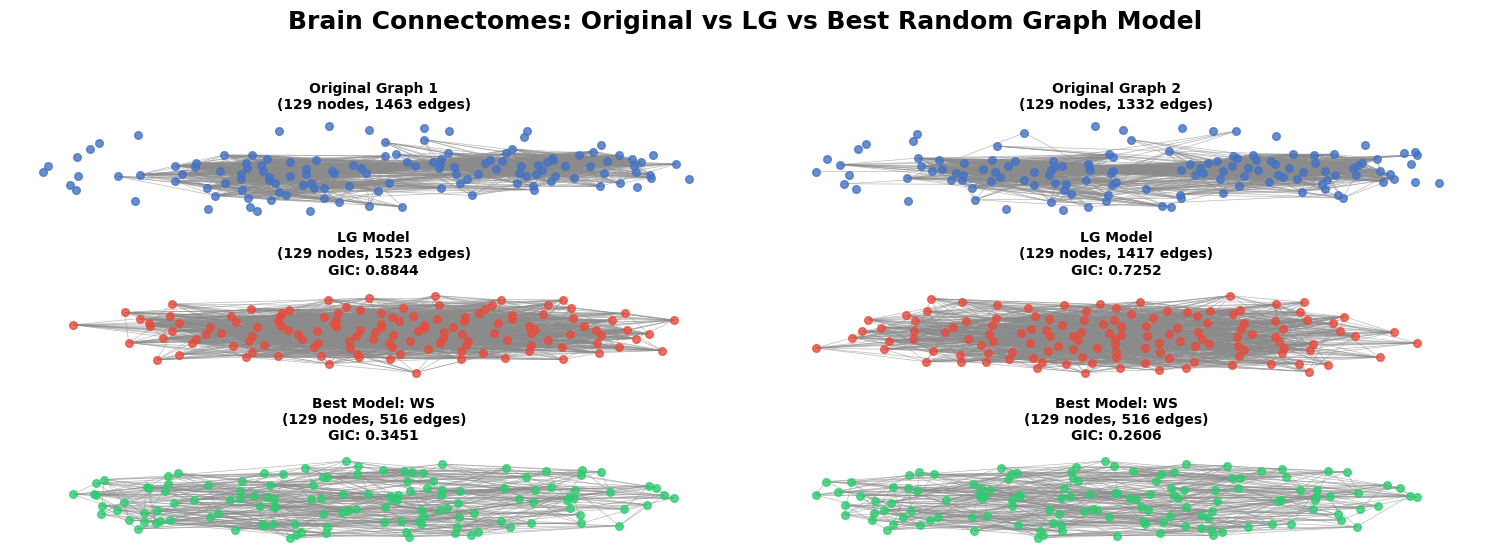

In [ ]:
# Create the comparison visualization
fig_model_comparison = visualize_model_comparison(
    model_results, 
    figsize=(15, 6), 
    node_size=30, 
    font_size=8, 
    edge_width=0.5
)

In [75]:
import pickle
import os
os.makedirs(f'runs/model_comparison_braingraph_{DATASET}', exist_ok=True)

# Save the complete results
with open(f'runs/model_comparison_braingraph_{DATASET}/model_comparison_results.pkl', 'wb') as f:
    pickle.dump(model_results, f)

model_results['summary_df'].to_csv(f'runs/model_comparison_braingraph_{DATASET}/model_comparison_results.csv', index=False)
df_graph_attr.to_csv(f'runs/model_comparison_braingraph_{DATASET}/graph_attributes.csv', index=False)


# Save the figure
os.makedirs(f'../images/model_comparison_braingraph_{DATASET}', exist_ok=True)
with open(f'../images/model_comparison_braingraph_{DATASET}/model_comparison_graphs.pkl', 'wb') as f:
    pickle.dump(fig_model_comparison, f)



In [ ]:
32183028301